In [1]:
import tensorflow as tf
import numpy as np
from sdm_ml.dataset import BBSDataset
from sklearn.preprocessing import StandardScaler
from block_diag import block_diagonal
from kernels import ard_rbf_kernel
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
csv_folder = '../../multi_species/bbs/dataset/csv_bird_data/'
dataset = BBSDataset(csv_folder)

In [3]:
training_set = dataset.get_training_set()

In [4]:
training_set.keys()

dict_keys(['covariates', 'outcomes'])

In [5]:
training_set['outcomes'].sum().sort_values(ascending=False).head()

Mourning Dove           1356
American Robin          1341
Red-winged Blackbird    1283
Brown-headed Cowbird    1229
American Crow           1224
dtype: int64

In [6]:
training_set['outcomes'].shape

(1612, 371)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

covariates = scaler.fit_transform(training_set['covariates'].values)
outcomes = training_set['outcomes'][['American Crow', 'Brown-headed Cowbird']]

scaler = StandardScaler()

# Keep only the first 200 rows and 2 outcomes for this test
covariates = scaler.fit_transform(covariates.astype(np.float32))[:200, :]
outcomes = outcomes.values[:200, :1]

/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
covariates.shape

(200, 8)

In [9]:
n_features = covariates.shape[1]
n_outcomes = outcomes.shape[1]
kern_size = covariates.shape[0] * n_outcomes

In [10]:
# Next steps:
# 1. Implement the ARD RBF kernel in tensorflow.
# 2. Implement the site kernel in tensorflow (should have derivation). --> Actually, defer this for now and just use the ARD.
# 3. Check that they look reasonable, maybe even on a super-small set.
# 4. Try to optimise with fixed hyperparameters.
# 5. Try to optimise the hyperparameters in an outer loop (Laplace approx.).
# 6. Compare speeds of sparse vs. non-sparse versions.

In [11]:
# Invent some length scales and variances
lengthscales = np.array([
    [4., 5., 2., 8., 3., 9., 5., 3.]
])

alphas = np.array([1.])

In [12]:
# Let's check what should happen with GPFLow
import gpflow

kern = gpflow.kernels.RBF(8, active_dims=range(8), lengthscales=lengthscales[0, :],
                          variance=alphas[0]**2)
likelihood = gpflow.likelihoods.Bernoulli()

model = gpflow.models.VGP(covariates.astype(np.float64), outcomes[:, [0]].astype(np.float64), kern=kern, 
                          likelihood=likelihood)

gpflow.train.ScipyOptimizer().minimize(model, maxiter=100, disp=True)

pred = model.predict_f(covariates.astype(np.float64))[0]

model.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 55.160605
  Number of iterations: 100
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 55.160605
  Number of iterations: 100
  Number of functions evaluations: 108


,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/variance,Parameter,None,+ve,True,(),True,11.583998288231706
VGP/kern/lengthscales,Parameter,None,+ve,True,"(8,)",True,"[2.6531830739579294, 4.732996336123339, 3.1924..."
VGP/q_mu,Parameter,None,(none),True,"(200, 1)",True,"[[-0.12044699365294084], [1.6339829625764235],..."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 200, 200)",True,"[[[0.18229711925219258, 0.0, 0.0, 0.0, 0.0, 0...."


In [13]:
k_sess = kern.enquire_session()
gpflow_kernel = k_sess.run(kern.K(covariates.astype(np.float64)))

In [14]:


#block_kernel = sess.run(block_kern, feed_dict={X: covariates})

In [15]:
#plt.matshow(block_kernel)
#plt.colorbar()

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_features))
y = tf.placeholder(tf.int64, shape=(None, n_outcomes))

y_flat = tf.cast(tf.reshape(y, (-1,)), tf.float32)

tf_scales = tf.Variable(initial_value=lengthscales, dtype=tf.float32)
tf_alphas = tf.Variable(initial_value=alphas, dtype=tf.float32)

ks = list()

# Maybe there would be a more efficient way for large numbers of species than doing it via this list.

for cur_k in range(n_outcomes):
    
    cur_scales = tf_scales[cur_k, :]
    cur_alpha = tf_alphas[cur_k]    
    cur_kernel = ard_rbf_kernel(X, X, cur_scales, cur_alpha)
    ks.append(cur_kernel)
    
block_kern = block_diagonal(ks)

In [17]:
f = tf.get_variable('f', shape=(kern_size, 1), initializer=tf.random_normal_initializer(stddev=0.01))

In [18]:
inv_kernel = tf.linalg.inv(block_kern)

In [19]:
log_prior = -0.5 * tf.matmul(tf.matmul(tf.transpose(f), inv_kernel), f)

# Log likelihood
log_lik = tf.reduce_sum(tf.expand_dims(y_flat, 1) * f - tf.nn.softplus(f))
log_post = tf.squeeze(log_prior) + log_lik
log_lik_naive = tf.expand_dims(y_flat, 1) * tf.log_sigmoid(f) + (1 - tf.expand_dims(y_flat, 1)) * tf.log(1 - tf.sigmoid(f))

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
optimiser = tf.contrib.opt.ScipyOptimizerInterface(
    -log_post, var_list=[f], options={'maxiter': 1000, 'disp': False})

In [21]:
non_gpflow_k = sess.run(ks[0], feed_dict={X: covariates})

In [22]:
probs = tf.nn.sigmoid(f)
W = -probs * (probs - 1)
W_sqrt = tf.diag(tf.squeeze(tf.sqrt(W)))
multiplied = tf.matmul(tf.matmul(W_sqrt, block_kern), W_sqrt)

# Add on the identity
with_id = tf.eye(kern_size) + multiplied
det_term = tf.linalg.logdet(with_id)

log_marg_lik = tf.squeeze(log_prior) + log_lik - 0.5 * det_term

In [23]:
scale_grad = tf.gradients(log_marg_lik, tf_scales)
alpha_grad = tf.gradients(log_marg_lik, tf_alphas)

step_size = 1e-3

scale_update = tf.assign(tf_scales, tf_scales + step_size * scale_grad[0])
alpha_update = tf.assign(tf_alphas, tf_alphas + step_size * alpha_grad[0])

In [31]:
test_grad = tf.gradients(log_marg_lik, [tf_scales, tf_alphas])


In [35]:
test_grad

[<tf.Tensor 'gradients_4/strided_slice_grad/StridedSliceGrad:0' shape=(1, 8) dtype=float32>,
 <tf.Tensor 'gradients_4/strided_slice_1_grad/StridedSliceGrad:0' shape=(1,) dtype=float32>]

In [24]:
# Alternatively, try to optimise the marginal likelihood to convergence
marg_lik_opt = tf.contrib.opt.ScipyOptimizerInterface(
    -log_marg_lik, var_list=[tf_scales, tf_alphas], options={'disp': True})

In [25]:
for i in range(100):

    # Find optimum
    optimiser.minimize(sess, feed_dict={X: covariates, y: outcomes})

    # Take step in direction of log marginal likelihood
    new_marg_lik, new_scales, new_alpha = sess.run([log_marg_lik, scale_update, alpha_update], 
                                                   feed_dict={X: covariates, y: outcomes})
    
    #marg_lik_opt.minimize(sess, feed_dict={X: covariates, y: outcomes})

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.439819
  Number of iterations: 248
  Number of functions evaluations: 269


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 87.439819
  Number of iterations: 248
  Number of functions evaluations: 269


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.062149
  Number of iterations: 2
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.062149
  Number of iterations: 2
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.006386
  Number of iterations: 6
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.006386
  Number of iterations: 6
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.118874
  Number of iterations: 3
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 84.118874
  Number of iterations: 3
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.002319
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 83.002319
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.566948
  Number of iterations: 9
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.566948
  Number of iterations: 9
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.189377
  Number of iterations: 3
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 82.189377
  Number of iterations: 3
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.933304
  Number of iterations: 2
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.933304
  Number of iterations: 2
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.593475
  Number of iterations: 3
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.593475
  Number of iterations: 3
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.662285
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.662285
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.011986
  Number of iterations: 7
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 81.011986
  Number of iterations: 7
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.836884
  Number of iterations: 1
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.836884
  Number of iterations: 1
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.470291
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.470291
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.912796
  Number of iterations: 4
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.912796
  Number of iterations: 4
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.999428
  Number of iterations: 2
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.999428
  Number of iterations: 2
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.135651
  Number of iterations: 2
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 80.135651
  Number of iterations: 2
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.647888
  Number of iterations: 7
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.647888
  Number of iterations: 7
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.944183
  Number of iterations: 2
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.944183
  Number of iterations: 2
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.463577
  Number of iterations: 5
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.463577
  Number of iterations: 5
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.621300
  Number of iterations: 2
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.621300
  Number of iterations: 2
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.481003
  Number of iterations: 3
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.481003
  Number of iterations: 3
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.762993
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.762993
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 79.257729
  Number of iterations: 3
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 79.257729
  Number of iterations: 3
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.124916
  Number of iterations: 3
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79.124916
  Number of iterations: 3
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.949394
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.949394
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.912476
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.912476
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.519905
  Number of iterations: 4
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.519905
  Number of iterations: 4
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.545471
  Number of iterations: 4
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.545471
  Number of iterations: 4
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.551720
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.551720
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.261253
  Number of iterations: 6
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.261253
  Number of iterations: 6
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.480362
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.480362
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.461433
  Number of iterations: 6
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.461433
  Number of iterations: 6
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.196533
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.196533
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.964485
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.964485
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.771591
  Number of iterations: 2
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.771591
  Number of iterations: 2
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.882996
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.882996
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.939560
  Number of iterations: 4
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.939560
  Number of iterations: 4
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.075165
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.075165
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.215271
  Number of iterations: 3
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.215271
  Number of iterations: 3
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.052490
  Number of iterations: 4
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.052490
  Number of iterations: 4
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.746758
  Number of iterations: 7
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.746758
  Number of iterations: 7
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.490753
  Number of iterations: 3
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.490753
  Number of iterations: 3
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.693924
  Number of iterations: 4
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.693924
  Number of iterations: 4
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.533691
  Number of iterations: 5
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.533691
  Number of iterations: 5
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.590355
  Number of iterations: 2
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.590355
  Number of iterations: 2
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.530167
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.530167
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.504295
  Number of iterations: 2
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.504295
  Number of iterations: 2
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.360291
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.360291
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.078339
  Number of iterations: 4
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.078339
  Number of iterations: 4
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.078384
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.078384
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.072174
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77.072174
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.795700
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.795700
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.622093
  Number of iterations: 5
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.622093
  Number of iterations: 5
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.584404
  Number of iterations: 6
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.584404
  Number of iterations: 6
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.572304
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.572304
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.372299
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.372299
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.270813
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.270813
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.382942
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.382942
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.126129
  Number of iterations: 3
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.126129
  Number of iterations: 3
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.270172
  Number of iterations: 4
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.270172
  Number of iterations: 4
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.299767
  Number of iterations: 6
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.299767
  Number of iterations: 6
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.428955
  Number of iterations: 3
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.428955
  Number of iterations: 3
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.340645
  Number of iterations: 6
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.340645
  Number of iterations: 6
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.187218
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76.187218
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.763832
  Number of iterations: 7
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.763832
  Number of iterations: 7
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.869423
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.869423
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.910210
  Number of iterations: 3
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.910210
  Number of iterations: 3
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.901405
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.901405
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.690964
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.690964
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.785492
  Number of iterations: 2
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.785492
  Number of iterations: 2
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.655655
  Number of iterations: 3
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.655655
  Number of iterations: 3
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.734894
  Number of iterations: 3
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.734894
  Number of iterations: 3
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.711098
  Number of iterations: 7
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.711098
  Number of iterations: 7
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.682129
  Number of iterations: 3
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.682129
  Number of iterations: 3
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.763542
  Number of iterations: 3
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.763542
  Number of iterations: 3
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.699173
  Number of iterations: 2
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.699173
  Number of iterations: 2
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.631233
  Number of iterations: 4
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.631233
  Number of iterations: 4
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.606476
  Number of iterations: 3
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.606476
  Number of iterations: 3
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.776260
  Number of iterations: 3
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.776260
  Number of iterations: 3
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.629501
  Number of iterations: 6
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.629501
  Number of iterations: 6
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.744133
  Number of iterations: 4
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.744133
  Number of iterations: 4
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.619759
  Number of iterations: 6
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.619759
  Number of iterations: 6
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.578415
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.578415
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.587234
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.587234
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.276375
  Number of iterations: 4
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.276375
  Number of iterations: 4
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.240036
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.240036
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.029678
  Number of iterations: 3
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.029678
  Number of iterations: 3
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.138748
  Number of iterations: 2
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.138748
  Number of iterations: 2
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.252609
  Number of iterations: 4
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.252609
  Number of iterations: 4
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.262520
  Number of iterations: 5
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.262520
  Number of iterations: 5
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.350632
  Number of iterations: 4
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.350632
  Number of iterations: 4
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.345047
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.345047
  Number of iterations: 2
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.391914
  Number of iterations: 4
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.391914
  Number of iterations: 4
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.429253
  Number of iterations: 4
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.429253
  Number of iterations: 4
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.447945
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.447945
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.526611
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.526611
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.559746
  Number of iterations: 2
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.559746
  Number of iterations: 2
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.441475
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.441475
  Number of iterations: 2
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 75.529625
  Number of iterations: 0
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 75.529625
  Number of iterations: 0
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.392029
  Number of iterations: 3
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.392029
  Number of iterations: 3
  Number of functions evaluations: 21


In [26]:
f_opt = sess.run(f).reshape(-1, 1)

In [30]:
sess.run(log_marg_lik, feed_dict={
    X: covariates, y: outcomes, 
    tf_scales: np.expand_dims(np.linspace(2, 3, 8), axis=0)})

-91.59469

Text(0,0.5,'VGP')

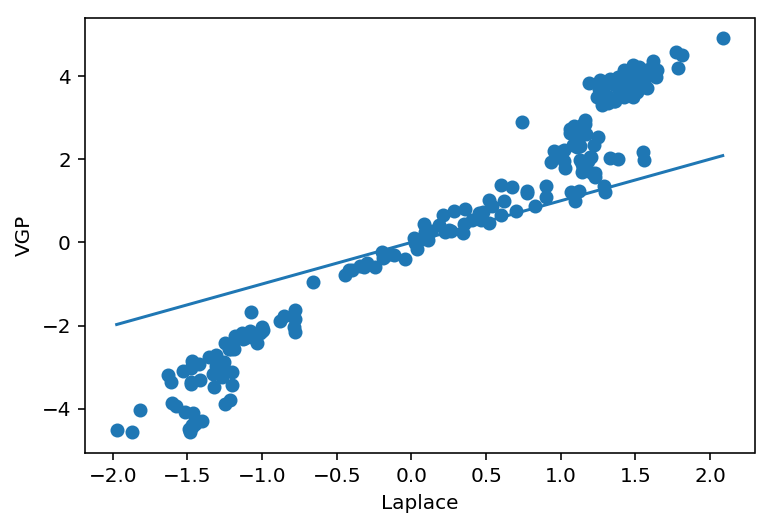

In [27]:
plt.scatter(np.squeeze(f_opt[:, 0]), np.squeeze(pred))
plt.plot([np.min(f_opt), np.max(f_opt)], [np.min(f_opt), np.max(f_opt)])
plt.xlabel('Laplace')
plt.ylabel('VGP')

In [28]:
sess.run(tf_scales)

array([[3.9295974, 4.9502687, 1.904096 , 8.005562 , 2.9473736, 9.001448 ,
        4.977209 , 2.9314525]], dtype=float32)